In [1]:
# -*- coding: utf-8 -*-
"""
Author: Ang Ming Liang

Based on https://github.com/probml/pmtk3/blob/master/demos/ebBinom.m

See also https://github.com/ericsuh/dirichlet

"""


import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from scipy.special import digamma
import os
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [2]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [3]:
# fmt: off
y = np.array( [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 
               2, 5, 3, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 
               6, 16, 15, 15, 9, 4, ] )
n = np.array( [ 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 25, 24, 23,
               20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 
               20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14, ] )
# fmt: on

X = np.array([y, n - y]).T


def dirichlet_moment_match(data):
    a = np.mean(data, axis=0)
    m2 = np.mean(data * data, axis=0)
    ok = a > 0
    s = (a[ok] - m2[ok]) / (m2[ok] - a[ok] ** 2)
    s = np.median(s)
    if s == 0:
        s = 1
    return a * s


def polya_moment_match(data):
    sdata = np.expand_dims(np.sum(X, axis=1), axis=1)
    p = data / sdata
    a = dirichlet_moment_match(p)
    return a


def polya_fit_simple(data):
    a = polya_moment_match(data)
    N, K = data.shape
    for _ in range(100):
        sa = np.sum(a)
        g = np.sum(digamma(data + a), axis=0) - N * digamma(a)
        h = sum(digamma(np.sum(X, axis=1) + np.sum(a))) - N * digamma(np.sum(a))
        a = a * g / h
    return a

In [4]:
alphas = polya_fit_simple(X)
a, b = alphas

popMean = a / (a + b)
aPost = a + y
bPost = b + n - y
meantheta = aPost / (aPost + bPost)
quartiles = np.array(
    [[beta.ppf(0.25, a, b), beta.ppf(0.75, a, b), beta.ppf(0.50, a, b)] for (a, b) in zip(aPost, bPost)]
)
CItheta, mediantheta = quartiles[:, :2], quartiles[:, 2]

alpha_mean = np.mean(aPost)
beta_mean = np.mean(bPost)
hyper_mean = alpha_mean / (alpha_mean + beta_mean)
print("hyper mean")
print(hyper_mean)


thetaMLE = y / n
thetaPooledMLE = np.sum(y) / np.sum(n)
x = np.arange(0, len(y))

hyper mean
0.14987193899618548


In [5]:
pml.latexify(fig_width=6 * 0.5, fig_height=3)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


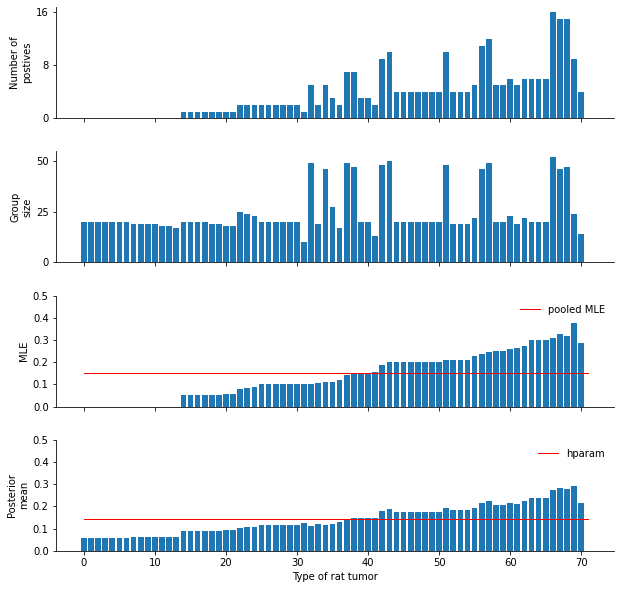

In [6]:
# Plot
FIG_SIZE = None if pml.is_latexify_enabled() else (10, 10)

J = len(n)
fig, axs = plt.subplots(4, 1, figsize=FIG_SIZE, sharex=True)
plt.subplots_adjust(hspace=0.3)
axs = np.reshape(axs, 4)

xs = np.arange(J)
ax = axs[0]
ax.bar(xs, y)
ax.set_ylabel("Number of\npostives")
sns.despine()
ax.set_yticks([0, 8, 16])

ax = axs[1]
ax.bar(xs, n)
ax.set_ylabel("Group\nsize")
ax.set_yticks([0, 25, 50])
sns.despine()

ax = axs[2]
ax.set_ylim(0, 0.5)
ax.bar(x, thetaMLE)
ax.plot([0, len(thetaMLE)], [thetaPooledMLE, thetaPooledMLE], color="red", linewidth=1, label="pooled MLE")
ax.set_ylabel("MLE")
sns.despine()
ax.legend(frameon=False)


ax = axs[3]
ax.bar(x, meantheta)
ax.plot([0, len(meantheta)], [popMean, popMean], color="red", linewidth=1, label="hparam")
ax.set_ylim(0, 0.5)
ax.set_ylabel("Posterior\nmean")
sns.despine()
ax.legend(frameon=False)


ax.set_xlabel("Type of rat tumor")
ax.set_xticks(range(0, 71, 10))
pml.savefig("eb_binom_rats_barplot", tight_bbox=True)
plt.show()

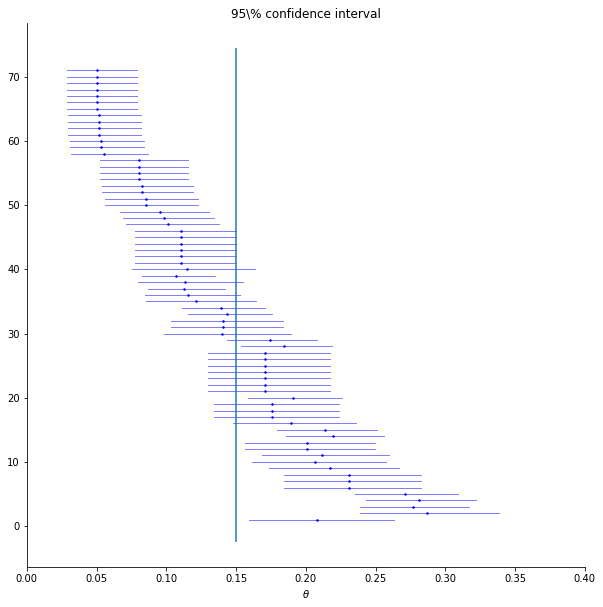

In [7]:
plt.figure(figsize=FIG_SIZE)
plt.title("95\% confidence interval")
# for (height, q, median) in zip(range(len(n)-1, 1, -1), CItheta, mediantheta):
for j in range(J):
    height = J - j
    q = CItheta[j]
    median = mediantheta[j]
    plt.plot([q[0], q[1]], [height, height], "b", alpha=0.5, lw=1)
    plt.plot(median, height, "bo", markersize=1.5)
# plt.yticks(x)
ax = plt.gca()
ax.set_xlim(0, 0.4)
y_lims = ax.get_ylim()
ax.vlines(hyper_mean, *y_lims)
sns.despine()
ax.set_xlabel("$\\theta$")
pml.savefig("eb_binom_rats_CI")